# Set-up

## Imports

In [2]:
# Standard
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

# Plotting
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 200
import seaborn as sns
sns.set_theme()
from tqdm.notebook import tqdm, trange
import plotly.graph_objects as go

# Sci-kit learn imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score, f1_score, classification_report, matthews_corrcoef, PrecisionRecallDisplay
import joblib

## Parameters

In [40]:
scope = 'BID'
input_path = f'../data/3_output/ML_dataset_{scope}.pkl'

start_month = 201901
end_month = 202212

subsample_size = None

target = 'Result'

## Functions

In [4]:
def APS(groupby):
    return average_precision_score(groupby[target], groupby['y_probs'])

In [35]:
def get_APS_per_group(df, group, plot=True, plot_kind='bar', **kwargs):
    aps_df = df.groupby(group, as_index=False).apply(APS).rename({None: 'APS'}, axis=1)
    aps_df.sort_values(group, inplace=True)
    aps_df[group[0]] = aps_df[group[0]].astype(str)
    if plot:
        if len(group) > 1:
            aps_df.pivot(index=group[0], columns=group[1], values="APS").plot(kind='bar', **kwargs)
        else:
            aps_df.set_index(group[0]).plot(kind=plot_kind, legend=False, **kwargs)
        plt.xlabel(group[0])
        plt.xticks(rotation=0)
        plt.ylabel('Average Precision Score (APS)')
        plt.ylim((0,1))
        plt.title('{} bids APS per {}'.format(scope, group[0]))
        plt.savefig('../plots/{}/aps_{}_{}.png'.format(scope, '_'.join(group), scope.lower()))
        plt.show()

    return aps_df

In [6]:
def get_acc_rate_per_group(df, group, plot=True, **kwargs):
    rate_df = df.groupby(group, as_index=False)["Result"].mean()
    rate_df[group[0]] = rate_df[group[0]].astype(str)
    if plot:
        if len(group) > 1:
            rate_df.pivot(index=group[0], columns=group[1], values="Result").plot(kind='bar', **kwargs)
        else:
            rate_df.set_index(group[0]).plot(kind='bar', legend=False, **kwargs)
        plt.xlabel(group[0])
        plt.xticks(rotation=0)
        plt.ylabel('Acceptance rate')
        plt.title('{} bids acceptance rate per {}'.format(scope, group[0]))
        plt.savefig('../plots/{}/acc_{}_{}.png'.format(scope, '_'.join(group), scope.lower()))
        plt.show()

    return rate_df

# Main

## Load dataset & model predictions

In [41]:
# Load dataset
input_df = pd.read_pickle(input_path)
df = input_df.copy()
# Select only observations for which we generated a prediction
df['yearmonth'] = df.index.str[:6].astype(int)
df['month'] = df.index.str[4:6].astype(int)
df = df[(df.yearmonth >= start_month) & (df.yearmonth <= end_month)]
df

,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,WorkDay,Prov,Tech,PVold,PVnew,Price,PriceDiff,Result,yearmonth,month
2019010110UP_ALTOADDA_1_BID,10,20190101,2019,UP_ALTOADDA_1,BID,-0.133816,0.398355,-3.100278,0.134946,-0.401592,...,holiday,Milano,Hydro Run-of-river and poundage,0.004,0.004,51.22,0.344,False,201901,1
2019010111UP_ALTOADDA_1_BID,11,20190101,2019,UP_ALTOADDA_1,BID,0.528562,0.763957,-2.645589,0.396892,-0.401592,...,holiday,Milano,Hydro Run-of-river and poundage,0.004,0.004,51.22,0.193,False,201901,1
2019010113UP_ALTOADDA_1_BID,13,20190101,2019,UP_ALTOADDA_1,BID,1.708273,0.644079,-2.019727,0.631818,-0.401592,...,holiday,Milano,Hydro Run-of-river and poundage,0.066,0.066,51.22,0.022,False,201901,1
2019010114UP_ALTOADDA_1_BID,14,20190101,2019,UP_ALTOADDA_1,BID,2.600707,1.395362,-2.186984,0.634858,-0.401592,...,holiday,Milano,Hydro Run-of-river and poundage,0.066,0.066,51.22,0.110,False,201901,1
2019010116UP_ALTOADDA_1_BID,16,20190101,2019,UP_ALTOADDA_1,BID,-0.146270,-0.320653,-2.556509,0.277399,-0.401592,...,holiday,Milano,Hydro Run-of-river and poundage,0.028,0.028,51.22,-0.023,False,201901,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022123117UP_VOGHERA_1_BID,17,20221231,2022,UP_VOGHERA_1,BID,0.237656,-2.008471,-1.806319,0.875068,-2.527147,...,holiday,Pavia,Fossil Gas,0.540,0.540,135.00,-0.350,False,202212,12
2022123118UP_VOGHERA_1_BID,18,20221231,2022,UP_VOGHERA_1,BID,0.055686,-2.259989,-1.329127,0.607693,-2.561474,...,holiday,Pavia,Fossil Gas,1.000,1.000,136.00,-0.420,True,202212,12
2022123119UP_VOGHERA_1_BID,19,20221231,2022,UP_VOGHERA_1,BID,-0.051126,-2.357014,-1.293692,0.548271,-2.484197,...,holiday,Pavia,Fossil Gas,1.000,1.000,138.00,-0.414,True,202212,12
2022123120UP_VOGHERA_1_BID,20,20221231,2022,UP_VOGHERA_1,BID,-0.029177,-2.330178,-1.385200,0.630366,-2.484197,...,holiday,Pavia,Fossil Gas,1.000,1.000,141.00,-0.405,True,202212,12


In [8]:
# Load model predictions
y_probs = pd.read_pickle(f'{scope}/model_predictions/predicted_probs_monthly_recal_rolling_12m.pkl')
df['y_probs'] = y_probs

## Performance analysis

### Overall performance per year

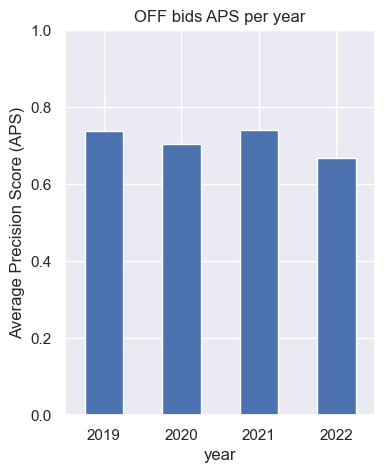

In [10]:
aps_df = get_APS_per_group(df, group=['year'], figsize=(4,5))

In [11]:
aps_df

,year,APS
0,2019,0.739510
1,2020,0.703655
2,2021,0.740727
3,2022,0.668945


### Overall performance per hour

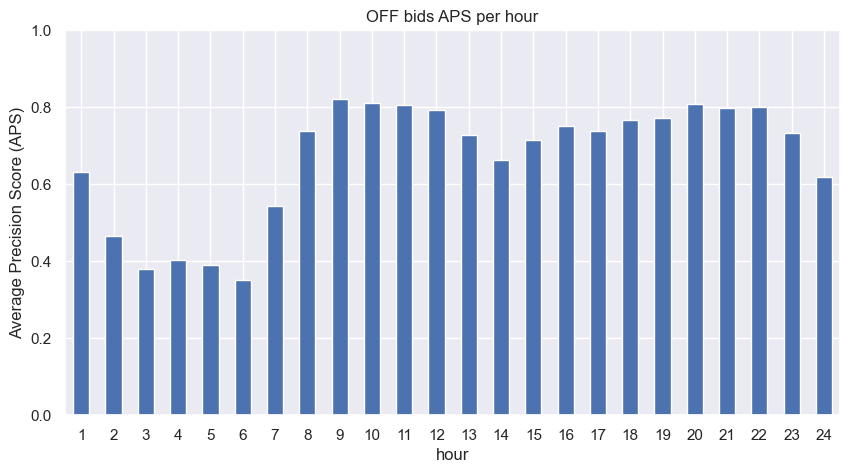

,hour,APS
0,1,0.632329
1,2,0.464434
2,3,0.381117
3,4,0.404416
4,5,0.389817
5,6,0.350064
6,7,0.544793
7,8,0.739213
8,9,0.820481
9,10,0.811759


In [12]:
aps_df = get_APS_per_group(df, group=['hour'], figsize=(10,5))
aps_df

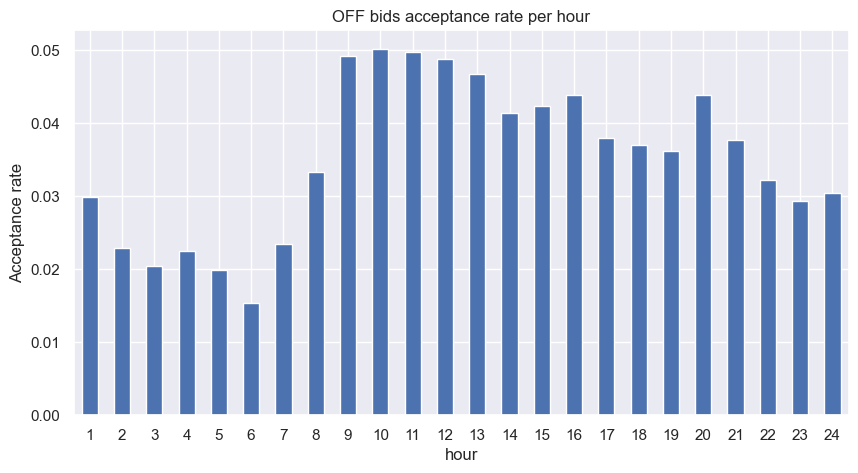

,hour,Result
0,1,0.029885
1,2,0.022915
2,3,0.020489
3,4,0.022537
4,5,0.019896
5,6,0.015401
6,7,0.023426
7,8,0.033341
8,9,0.049176
9,10,0.050177


In [13]:
acc_df = get_acc_rate_per_group(df, ["hour"], figsize=(10,5))
acc_df

So it seems that it is the acceptance rate that drives the variability in the performance of the model

### Overall performance per month

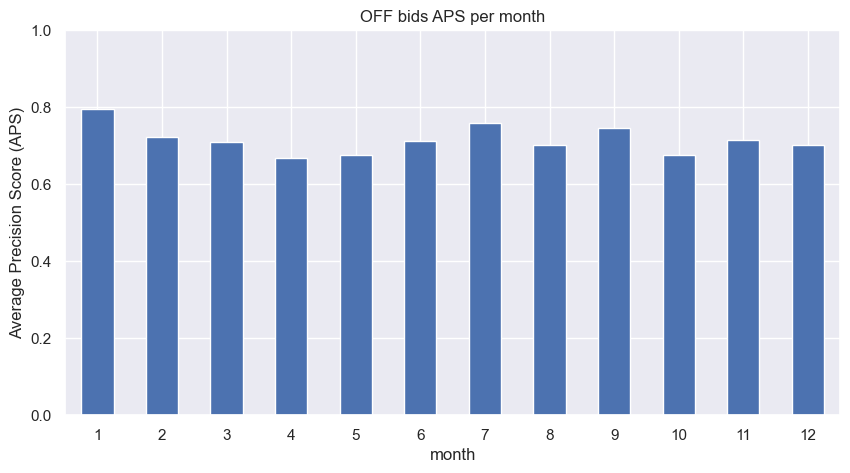

,month,APS
0,1,0.795138
1,2,0.723846
2,3,0.708735
3,4,0.668436
4,5,0.675940
5,6,0.712261
6,7,0.759197
7,8,0.702486
8,9,0.744964
9,10,0.675698


In [14]:
aps_df = get_APS_per_group(df, group=['month'], figsize=(10,5))
aps_df

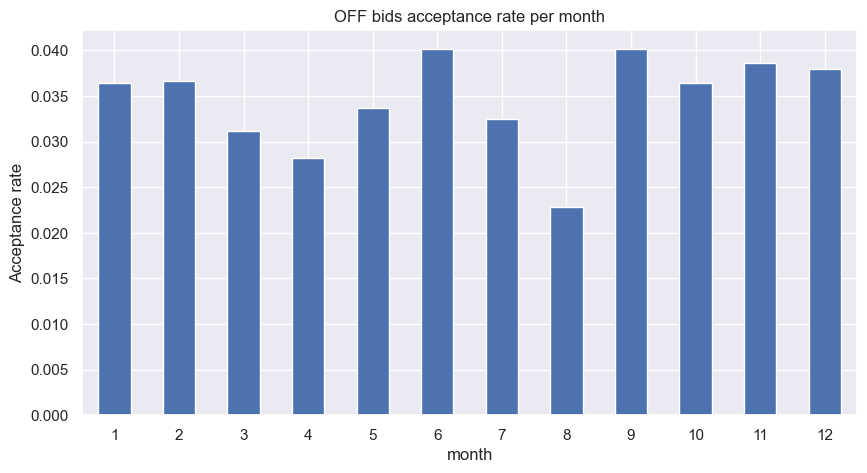

,month,Result
0,1,0.036406
1,2,0.036605
2,3,0.031193
3,4,0.028153
4,5,0.033721
5,6,0.040205
6,7,0.032513
7,8,0.022800
8,9,0.040181
9,10,0.036401


In [15]:
acc_df = get_acc_rate_per_group(df, ["month"], figsize=(10,5))
acc_df

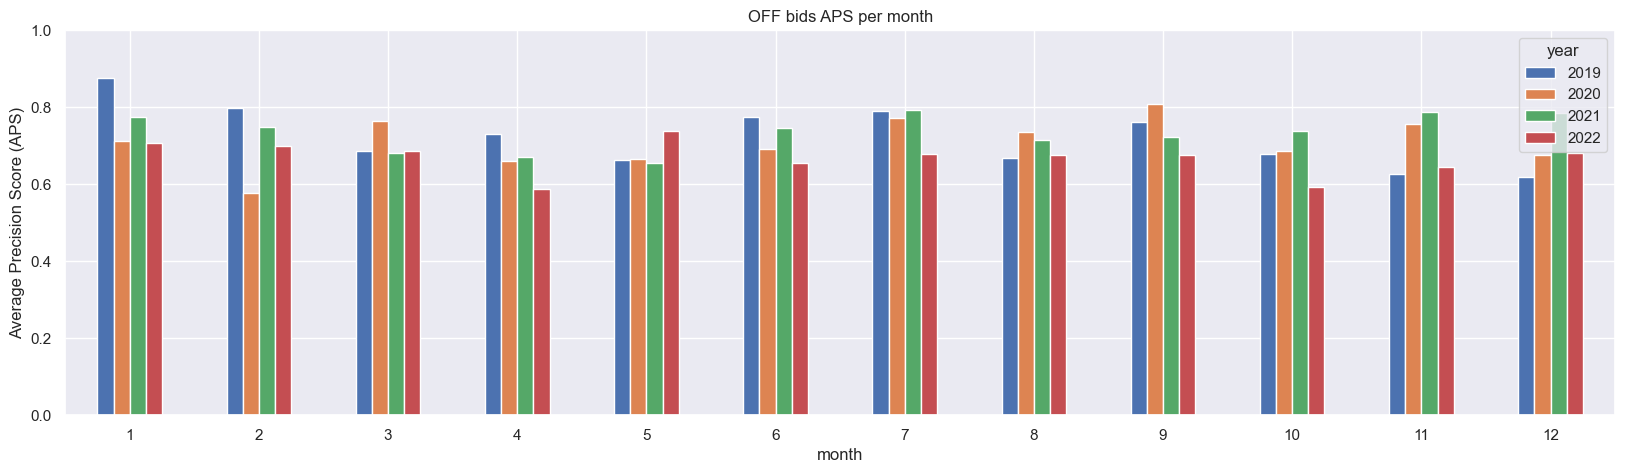

In [24]:
aps_df = get_APS_per_group(df, group=['month', 'year'], figsize=(20,5))

### Overall performance per technology

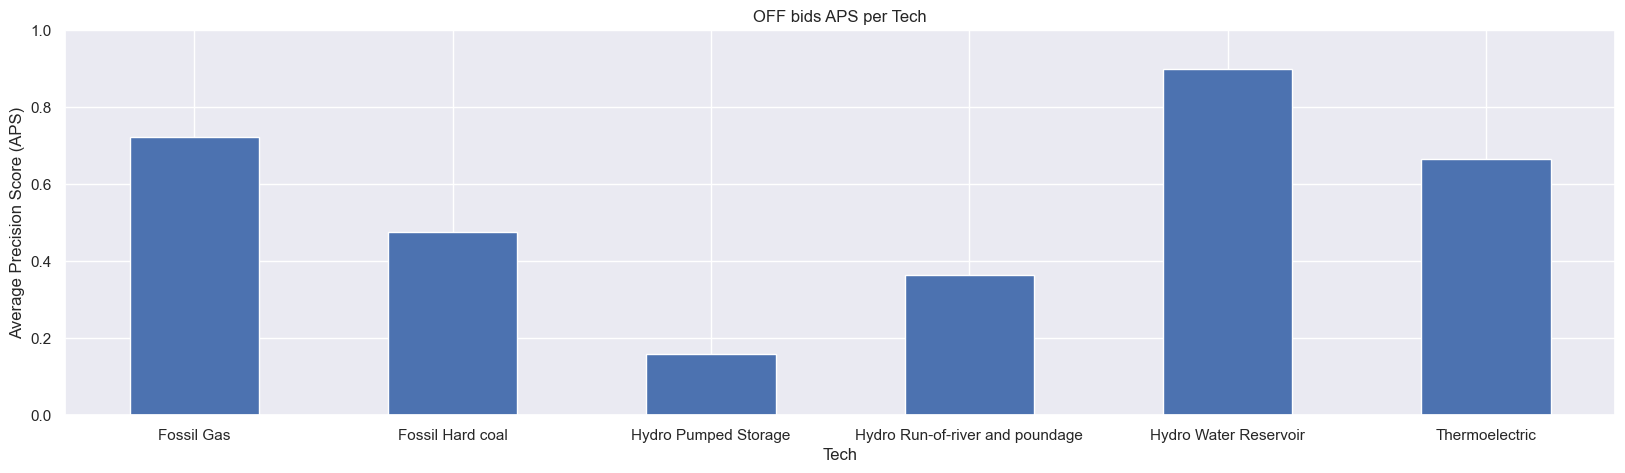

,Tech,APS
0,Fossil Gas,0.724001
1,Fossil Hard coal,0.475378
2,Hydro Pumped Storage,0.160323
3,Hydro Run-of-river and poundage,0.363485
4,Hydro Water Reservoir,0.899833
5,Thermoelectric,0.666274


In [25]:
aps_df = get_APS_per_group(df, group=['Tech'], figsize=(20,5))
aps_df

In [26]:
df.Tech.value_counts()

Tech
Fossil Gas                         817752
Hydro Water Reservoir              787059
Hydro Pumped Storage               503674
Hydro Run-of-river and poundage    329261
Thermoelectric                     171779
Fossil Hard coal                   154974
Name: count, dtype: int64

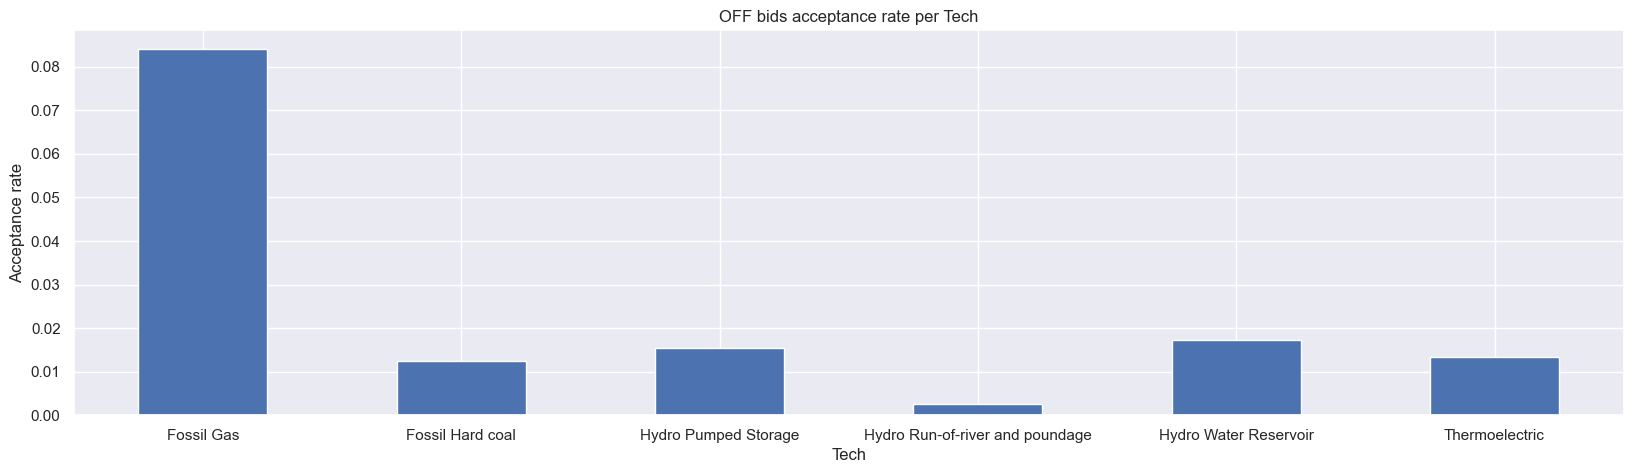

In [27]:
acc_df = get_acc_rate_per_group(df, ["Tech"], figsize=(20,5))

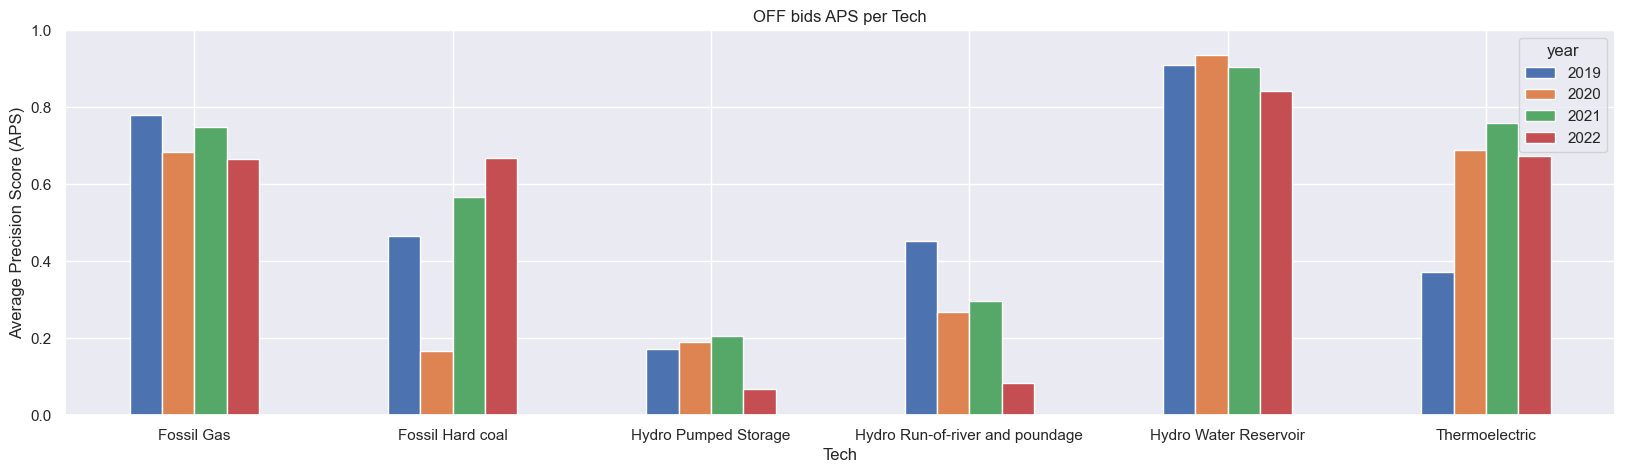

In [28]:
aps_df = get_APS_per_group(df, group=['Tech', 'year'], figsize=(20,5))

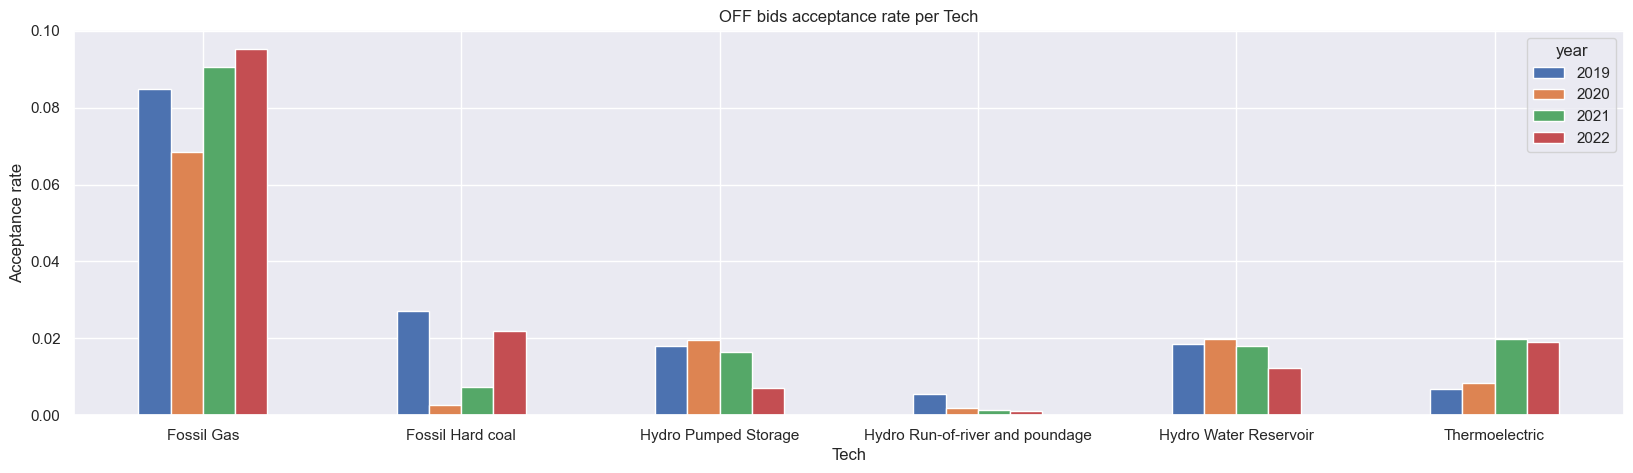

In [21]:
acc_df = get_acc_rate_per_group(df, ["Tech", "year"], figsize=(20,5))

### Time series of monthly performance

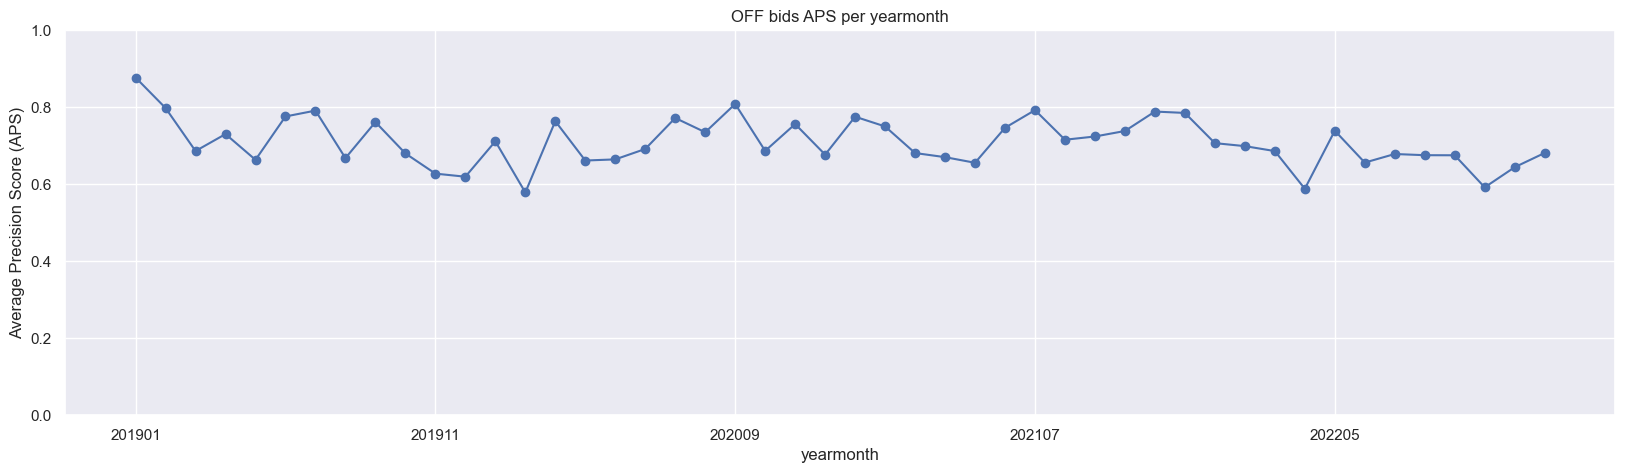

In [36]:
aps_df = get_APS_per_group(df, group=['yearmonth'], plot_kind='line', figsize=(20,5), marker='o')

In [42]:
input_df.to_csv(input_path.replace('.pkl', '.csv'))